# Scoring Experiment

In [72]:
# imports
import spacy
from transformers import AutoTokenizer, AutoModel
import phunspell
import torch
import matplotlib.pyplot as plt
import numpy as np

### Load NLP Tools
#### spacy
We use spaCy for natural language processing (NLP) tasks such as tokenization and lemmatization

In [2]:
nlp = spacy.load('nl_core_news_sm')

Download the dutch spacy model if necessary
```bash
python -m spacy download nl_core_news_sm
```

#### Hunspell
Because the original Hunspell libraries are outdated, we use a wrapper library called Phunspell. Phunspell allows us to perform spell-checking and corrections more efficiently in Python.


In [3]:
spell_checker = phunspell.Phunspell('nl_NL')

#### BERTje
BERTje is a Dutch language model based on Google's BERT architecture. It is specifically trained on Dutch text, making it highly effective for tasks like semantic similarity comparison and text embeddings. We use BERTje to measure the similarity between student answers and model answers to provide accurate scoring.

In [4]:
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
bertje_model = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")

Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Test data
Sample question and both a correct and incorrect student answer

In [103]:
model_answer = "Inflatie is het algemene prijsniveau van goederen en diensten dat in de tijd stijgt, wat leidt tot een afname van de koopkracht."
keywords =  ["inflatie", "prijsniveau", "goederen", "diensten", "tijd", "stijgt", "koopkracht"]
student_answer = "Inflatie is wanneer de prijzen van producten en diensten stijgen, waardoor je minder kunt kopen met hetzelfde geld."

## Step 1: Lemmatization

In [104]:
# Lemmatize model_answer
model_answer_doc = nlp(model_answer)
lemmatized_model_answer = " ".join([token.lemma_ for token in model_answer_doc])
print("Lemmatized Model Answer:", lemmatized_model_answer)

# Lemmatize keywords
lemmatized_keywords = [nlp(keyword)[0].lemma_ for keyword in keywords]
print("Lemmatized Keywords:", lemmatized_keywords)

# Lemmatize student answer
student_doc = nlp(student_answer)
lemmatized_answer = " ".join([token.lemma_ for token in student_doc])
print("Lemmatized Answer:", lemmatized_answer)

Lemmatized Model Answer: inflatie zijn het algemeen prijsniveau van goed en dienst dat in de tijd stijgen , wat leiden tot een afname van de koopkracht .
Lemmatized Keywords: ['inflatie', 'prijsniveau', 'goed', 'dienst', 'tijd', 'stijgen', 'koopkracht']
Lemmatized Answer: inflatie zijn wanneer de prijs van product en dienst stijgen , waardoor je weinig kunnen kopen met hetzelfde geld .


## Step 2: Spell Checking with Phunspell
TODO: Validate spellchecking

In [105]:
import string

## Step 2: Spell Checking with Phunspell (Updated)

# Remove punctuation before spell-checking
translator = str.maketrans('', '', string.punctuation)
lemmatized_answer_no_punctuation = lemmatized_answer.translate(translator)

# Count spelling mistakes and store wrong words with their corrections
misspelled_count = 0
misspelled_words = {}

corrected_tokens = []
tokens_with_punctuation = lemmatized_answer.split()  # To track punctuation

for i, word in enumerate(lemmatized_answer_no_punctuation.split()):
    original_word = tokens_with_punctuation[i]
    if not spell_checker.lookup(word):  # Word is misspelled
        misspelled_count += 1
        suggested_correction = list(spell_checker.suggest(word))
        corrected_word = suggested_correction[0] if suggested_correction else word
        misspelled_words[original_word] = corrected_word
        corrected_tokens.append(corrected_word)
    else:
        corrected_tokens.append(word)

corrected_answer = " ".join(corrected_tokens)

print("Corrected Answer:", corrected_answer)
print("Number of Spelling Mistakes:", misspelled_count)
print("Misspelled Words and Corrections:", misspelled_words)

Corrected Answer: inflatie zijn wanneer de prijs van product en dienst stijgen waardoor je weinig kunnen kopen met hetzelfde geld
Number of Spelling Mistakes: 0
Misspelled Words and Corrections: {}


## Step 3: Keyword Matching
TODO: Expand and validate

In [106]:
keyword_score = sum(1 for word in lemmatized_keywords if word in corrected_answer.lower()) / len(keywords)
print("Keyword Score:", keyword_score)

Keyword Score: 0.42857142857142855


## Step 4: Semantic Similarity with BERTje

### 4.1 Using [CLS] tokens
The [CLS] token provides a compact representation of the entire input sequence, making it ideal for tasks like classification

In [107]:
# Get the embeddings for the student answer
inputs_student = tokenizer(corrected_answer, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    student_output = bertje_model(**inputs_student)
    student_cls_embedding = student_output.last_hidden_state[:, 0, :]  # First token is [CLS]

# Get the embeddings for the model answer
inputs_model = tokenizer(model_answer, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    model_output = bertje_model(**inputs_model)
    model_cls_embedding = model_output.last_hidden_state[:, 0, :]  # First token is [CLS]

# Compute the cosine similarity between the [CLS] token embeddings
similarity_score = torch.nn.functional.cosine_similarity(student_cls_embedding, model_cls_embedding).item()
print("Semantic Similarity Score using [CLS] token:", similarity_score)

Semantic Similarity Score using [CLS] token: 0.6917760372161865


### 4.2 Using the Mean of Token Embeddings
averaging token embeddings captures a broader context by considering all words in the sentence, which can be useful for tasks requiring more nuanced understanding

In [108]:
inputs = tokenizer(corrected_answer, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    student_embedding = bertje_model(**inputs).last_hidden_state.mean(dim=1)

inputs = tokenizer(lemmatized_model_answer, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    model_embedding = bertje_model(**inputs).last_hidden_state.mean(dim=1)

similarity_score = torch.nn.functional.cosine_similarity(student_embedding, model_embedding).item()
print("Semantic Similarity Score:", similarity_score)

Semantic Similarity Score: 0.8731160163879395


I will use the mean of token embeddings because it captures a more detailed and nuanced understanding of the entire sentence by considering the contribution of all words, which is important for tasks that require a deeper contextual understanding.








## Step 5: Compound Score Calculation

Final Score: 0.5619348049163818


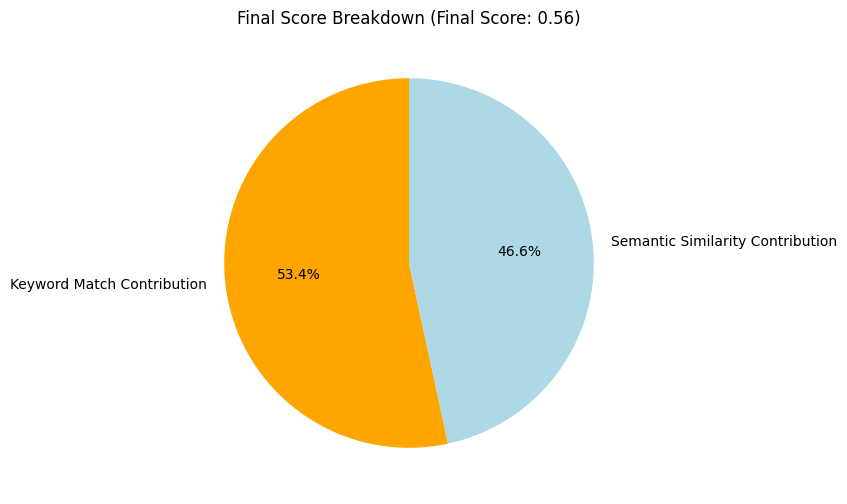

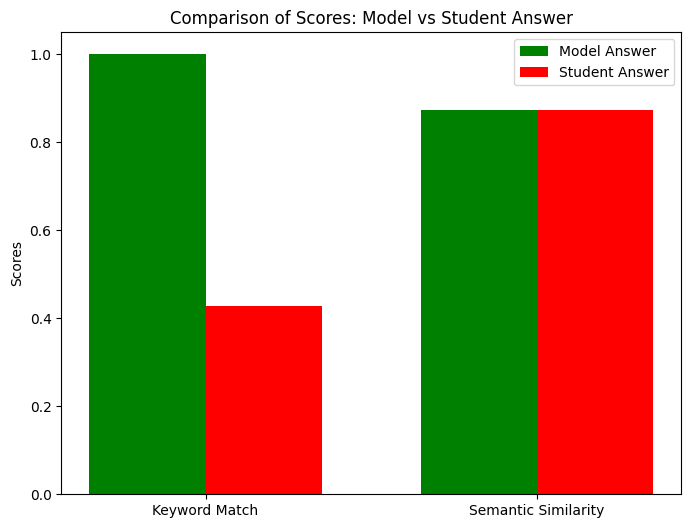

In [109]:
keyword_weight = 0.7 * keyword_score
similarity_weight = 0.3 * similarity_score
final_score = keyword_weight + similarity_weight

print("Final Score:", final_score)

# Plotting the compound score
scores = [keyword_weight, similarity_weight]
labels = ['Keyword Match Contribution', 'Semantic Similarity Contribution']

plt.figure(figsize=(8, 6))
plt.pie(scores, labels=labels, autopct='%1.1f%%', startangle=90, colors=['orange', 'lightblue'])
plt.title(f'Final Score Breakdown (Final Score: {final_score:.2f})')
plt.show()

# Plot a side-by-side bar chart comparing the student answer vs model answer in terms of keyword match and similarity
labels = ['Keyword Match', 'Semantic Similarity']
model_values = [1.0, similarity_score]  # Full match for model answer
student_values = [keyword_score, similarity_score]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))

rects1 = ax.bar(x - width/2, model_values, width, label='Model Answer', color='green')
rects2 = ax.bar(x + width/2, student_values, width, label='Student Answer', color='red')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Scores: Model vs Student Answer')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()